### Setup

In [15]:
import theano
import lasagne
import time
import itertools
import collections

import pandas as pd
import seaborn as sn
import numpy as np
import pickle
import theano.tensor as T
import keras
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sliding_window import sliding_window
from label_processing import reassign_labels
from label_processing import print_results
from label_processing import relabel_list
from keras import layers

# Hardcoded number of sensor channels employed in the OPPORTUNITY challenge
NB_SENSOR_CHANNELS = 113

# Hardcoded number of classes in the gesture recognition problem
NUM_CLASSES = 18

# Hardcoded length of the sliding window mechanism employed to segment the data
SLIDING_WINDOW_LENGTH = 24

# Length of the input sequence after convolutional operations
FINAL_SEQUENCE_LENGTH = 8

# Hardcoded step of the sliding window mechanism employed to segment the data
SLIDING_WINDOW_STEP = 12

# Batch Size
BATCH_SIZE = 100

# Number filters convolutional layers
NUM_FILTERS = 64

# Size filters convolutional layers
FILTER_SIZE = 5

# Number of unit in the long short-term recurrent layers
NUM_UNITS_LSTM = 128

### Load the sensor data

In [2]:
def load_dataset(filename):

    f = open(filename, 'rb')
    data = pickle.load(f)
    f.close()

    X_train, y_train = data[0]
    X_test, y_test = data[1]

    print(" ..from file {}".format(filename))
    print(" ..reading instances: train {0}, test {1}".format(X_train.shape, X_test.shape))

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    # The targets are casted to int8 for GPU compatibility.
    y_train = y_train.astype(np.uint8)
    y_test = y_test.astype(np.uint8)

    return X_train, y_train, X_test, y_test

print("Loading data...")
X_train, y_train, X_test, y_test = load_dataset('oppChallenge_locomotion.data')

def remove_class(X_train, y_train, X_test, y_test, class_n):
    uy_train = y_train[y_train != class_n]
    uX_train = X_train[y_train != class_n]
    uy_test = y_test[y_test != class_n]
    uX_test = X_test[y_test != class_n]
    
    classes = set(y_train)
    
    for x in range(class_n + 1, len(classes)):
        uy_train[uy_train == x] = x - 1
        uy_test[uy_test == x] = x - 1
        
    return uX_train, uy_train, uX_test, uy_test

def delete_features():
    # RKN^, RKN_, BACK, HIP, R-SHOE, L-SHOE
    # 53 Features
    
    features_delete = np.arange(6, 15) # 6,15
    # features_delete = np.concatenate([features_delete, np.arange(6, 113)])
    features_delete = np.concatenate([features_delete, np.arange(21, 36)])
    features_delete = np.concatenate([features_delete, np.arange(45, 81)])

    X_train = np.delete(X_train, features_delete, 1)
    X_test = np.delete(X_test, features_delete, 1)

classes = ["Null", "Stand", "Walk" ,"Sit", "Lie"]

# 0 - null | 1 - stand | 2 - walk | 3 - sit | 4 - lie

X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 0) # remove null
classes.remove("Null")

# X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 1) # remove walking
# classes.remove("Walk")

print(X_train.shape)
print(X_test.shape)

unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

Loading data...
 ..from file oppChallenge_locomotion.data
 ..reading instances: train (557963, 113), test (118750, 113)
(465668, 113)
(94260, 113)
{0: 231751, 1: 130506, 2: 88883, 3: 14528}


In [ ]:
def opp_sliding_window(data_x, data_y, ws, ss):
    data_x = sliding_window(data_x,(ws,data_x.shape[1]),(ss,1))
    data_y = np.asarray([[i[-1]] for i in sliding_window(data_y,ws,ss)])
    return data_x.astype(np.float32), data_y.reshape(len(data_y)).astype(np.uint8)

# Sensor data is segmented using a sliding window mechanism

X_train, y_train = opp_sliding_window(X_train, y_train, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)
X_test, y_test = opp_sliding_window(X_test, y_test, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)

print(" ..after sliding window (testing): inputs {0}, targets {1}".format(X_test.shape, y_test.shape))

#X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
#X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

# Data is reshaped since the input of the network is a 4 dimension tensor
#X_train = X_train.reshape((-1, 1, SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS))
#X_test = X_test.reshape((-1, 1, SLIDING_WINDOW_LENGTH, NB_SENSOR_CHANNELS))

print(X_train.shape)
print(X_test.shape)

In [ ]:
def mean_sliding_window(X):
    rows = X.shape[0]
    n_features = X.shape[2]
    window_mean = np.zeros((rows, n_features))
    for i in range(rows):
        window_mean[i] = np.mean(X_train[i],axis=0).reshape(1, n_features)
    return window_mean

s_X_train = mean_sliding_window(X_train)
s_X_test = mean_sliding_window(X_test)

print(s_X_train.shape)
print(s_X_test.shape)

In [10]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

NUMBER_OF_CLUSTERS = 6

# time the cluster

y_pred = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=0).fit(X_train).predict(X_test)

In [11]:
# 5 classes, swap label [4,3,2,1,0], ari: 0.22513280831129973, f1: 0.4609054391046733
# 4 classes, swap label [1,2,3,0],   ari: 0.31033466772971036, f1: 0.560081609271786  (no null)
# 3 classes,                         ari: 0.4724168184167218,  f1: 0.6375146352056416 (no null or walking)

uy_pred = y_pred.copy()
relabels = reassign_labels(uy_pred, y_test, set(uy_pred))
uy_pred = relabel_list(uy_pred, relabels)
print_results(uy_pred, y_test, relabels)

Assigned Labels:
[0, 2, 0, 3, 0, 1]

F1:
0.7104999996640843

Accuracy:
0.6777636325058349

ARI:
0.38193449919456157


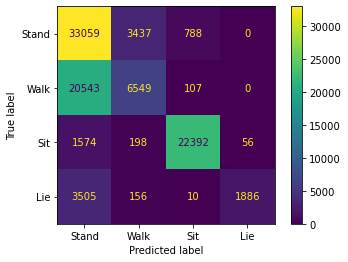

In [18]:
# Confusion Matrix
cm = metrics.confusion_matrix(y_test, uy_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp = disp.plot()

plt.show()

In [9]:
pca = PCA(n_components=0.99)
pca.fit(X_train)
X_pca = pca.transform(X_test)
# print('at', x, '% of the variance ======')
print("Original shape:   ", X_test.shape)
print("Transformed shape:", X_pca.shape)

#df_redd = pd.DataFrame(X_pca)
#X_traind, X_testd, y_traind, y_testd = train_test_split(df_redd, y_train)

y_pred = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=0).fit(X_pca).predict(X_pca)

uy_pred = y_pred.copy()
relabels = gridSearchLabel(uy_pred, y_test, set(uy_pred))
uy_pred = relabelList(uy_pred, relabels)
printResults(uy_pred, y_test, relabels)

Original shape:    (94260, 113)
Transformed shape: (94260, 80)


NameError: name 'gridSearchLabel' is not defined

In [ ]:
sliding_window = keras.Input(shape=(30, 113))

x = layers.Conv2D(112, (3, 3), activation='relu', padding='same')(sliding_window)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(112, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(sliding_window, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

In [ ]:
autoencoder1D = keras.Sequential(
    [
        layers.Input(shape=(30, 113)),
        layers.Conv1D(filters=64, kernel_size=7, padding="same", strides=15, activation="relu"),
        #layers.Dropout(rate=0.2),
        layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=15, activation="relu"),
        layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=15, activation="relu"),
        #layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(filters=64, kernel_size=7, padding="same", strides=15, activation="relu"),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
autoencoder1D.compile(optimizer='adam', loss="mse")
autoencoder1D.summary()

In [ ]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)

autoencoder1D.fit(X_train, X_train,
                epochs=50,
                batch_size=100,
                shuffle=True,
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
# should the autoencoder reduce the size of the sliding window?
# lstm autoencoder doesnt need a sliding window, redudent data can lead to overfitting

model = Sequential()
model.add(LSTM(108, activation='relu', input_shape=(SLIDING_WINDOW_LENGTH, 113), return_sequences=True))
model.add(LSTM(92, activation='relu', return_sequences=False))
model.add(Dense(86))
model.add(RepeatVector(SLIDING_WINDOW_LENGTH))
model.add(LSTM(92, activation='relu', return_sequences=True))
model.add(LSTM(108, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(113)))
model.compile(optimizer='adam', loss='mse')
model.summary()

In [ ]:
from keras.callbacks import TensorBoard


model.fit(X_train, X_train, epochs=10, batch_size=100, callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

In [ ]:
# encoder becomes output
encoder = keras.Model(inputs=model.inputs, outputs=model.layers[2].output)

In [ ]:
# get encoded data
encoded_train = encoder.predict(X_train, verbose=0)
encoded_test = encoder.predict(X_test, verbose=0)
print(encoded_train.shape)
print(encoded_test.shape)

In [ ]:
y_pred = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=0).fit(encoded_train).predict(encoded_test)

uy_pred = y_pred.copy()
relabels = gridSearchLabel(uy_pred, y_test, set(uy_pred))
uy_pred = relabelList(uy_pred, relabels)
printResults(uy_pred, y_test, relabels)